# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Final Project Group 40: Trump Tweets and Market Volatility


**Harvard University**<br/>
**Fall 2019**<br/>
**Group**: Dylan DeMarco, Daiki Ina, Roger Zhang, Jerry Huang

<hr style="height:2pt">

In [183]:
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import pandas_profiling

In [219]:
vix_df = pd.read_csv('./data/raw/vix_data.csv', index_col=0)
vix_df.Date = pd.to_datetime(vix_df.Date)
# We only use Open in our models
vix_df = vix_df.drop(columns=['VIX High', 'VIX Low', 'VIX Close'])
# Drop enough days to use DOW even in models where we don't need it for fair comparison
vix_df = vix_df.loc[vix_df.Date > '2016-11-16']
vix_df.shape

(748, 2)

In [220]:
tweet_df_raw = pd.read_csv('./data/raw/reference_date_5.csv', index_col=0)
tweet_df_full = tweet_df_raw.drop(columns="Unnamed: 0.1")
tweet_df_full.ref_date = pd.to_datetime(tweet_df_full.ref_date)

# splits into filtered (Trump only) and unflitered dfs
tweet_df_filtered = tweet_df_full[tweet_df_full['trump_classification_binary'] == 1]

In [221]:
# Group tweets
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
grouped_tweets_full = tweet_df_full.groupby('ref_date').agg({'polarity':['mean', 'max', 'min'], 
                                                   'word_mentions':'sum',
                                                  'DT': 'count'})
grouped_tweets_filtered = tweet_df_filtered.groupby('ref_date').agg({'polarity':['mean', 'max', 'min'], 
                                                   'word_mentions':'sum',
                                                  'DT': 'count'})



grouped_tweets_full.head(3)

polarity              word_mentions    DT
                mean    max   min           sum count
ref_date                                             
2016-11-10  0.450000  0.450  0.45             0     1
2016-11-11  0.399875  1.000  0.00             0     5
2016-11-14  0.345950  0.925 -0.70             0    10

In [222]:
dow_df = pd.read_csv('./data/raw/dow_range_past5days_data.csv')
dow_df.Date = pd.to_datetime(dow_df.Date)
dow_df.set_index("Date", inplace=True)
dow_df.head(3)

,dow_d_min_1,dow_d_min_2,dow_d_min_3,dow_d_min_4,dow_d_min_5
Date,,,,,
2016-11-17,83.958984,119.199219,118.300781,118.818359,270.519531
2016-11-18,58.759766,83.958984,119.199219,118.300781,118.818359
2016-11-21,61.910156,58.759766,83.958984,119.199219,118.300781


In [223]:
model_df_full = vix_df.join(grouped_tweets_full, how="left", on="Date")
model_df_full = model_df_full.join(dow_df, how="left", on="Date")
# Inpute with zero because we decide conservatively to disregard the effects of the previous day
# There are only 15 days with no tweets
model_df_full.fillna(0, inplace=True)

# model_df[('polarity', 'mean')]
model_df_filtered = vix_df.join(grouped_tweets_filtered, how="left", on="Date")
model_df_filtered = model_df_filtered.join(dow_df, how="left", on="Date")
# Inpute with zero because we decide conservatively to disregard the effects of the previous day
# There are only 15 days with no tweets
model_df_filtered.fillna(0, inplace=True)

display(model_df_full.describe())
display(model_df_filtered.describe())

/Users/dylandemarco/PSets/Venvs/CS109Venv/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,VIX Open,"(polarity, mean)","(polarity, max)","(polarity, min)","(word_mentions, sum)","(DT, count)",dow_d_min_1,dow_d_min_2,dow_d_min_3,dow_d_min_4,dow_d_min_5
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,14.427687,0.165556,0.698768,-0.301010,2.733957,12.052139,216.653062,216.654344,216.669708,216.674118,216.762406
std,4.154349,0.141405,0.293777,0.309617,3.914422,9.562797,175.734729,175.734014,175.724899,175.722399,175.732854
min,9.010000,-0.330556,0.000000,-1.000000,0.000000,0.000000,35.089844,35.089844,35.089844,35.089844,35.089844
25%,11.505000,0.075188,0.500000,-0.500000,0.000000,6.000000,104.114747,104.114747,104.114747,104.114747,104.114747
50%,13.205000,0.150982,0.750000,-0.272140,2.000000,10.000000,161.009765,161.009765,161.009765,161.009765,161.009765
75%,16.222500,0.234790,1.000000,-0.065427,4.000000,16.000000,273.887696,273.887696,273.887696,273.887696,273.887696
max,37.320000,0.966667,1.000000,0.900000,46.000000,71.000000,1596.648438,1596.648438,1596.648438,1596.648438,1596.648438


,VIX Open,"(polarity, mean)","(polarity, max)","(polarity, min)","(word_mentions, sum)","(DT, count)",dow_d_min_1,dow_d_min_2,dow_d_min_3,dow_d_min_4,dow_d_min_5
count,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000,748.000000
mean,14.427687,0.112089,0.477359,-0.250017,2.213904,7.871658,216.653062,216.654344,216.669708,216.674118,216.762406
std,4.154349,0.165232,0.289554,0.316646,3.304651,6.867232,175.734729,175.734014,175.724899,175.722399,175.732854
min,9.010000,-0.575000,-0.575000,-1.000000,0.000000,0.000000,35.089844,35.089844,35.089844,35.089844,35.089844
25%,11.505000,0.002310,0.297074,-0.437500,0.000000,3.000000,104.114747,104.114747,104.114747,104.114747,104.114747
50%,13.205000,0.100590,0.500000,-0.237240,1.000000,6.000000,161.009765,161.009765,161.009765,161.009765,161.009765
75%,16.222500,0.196186,0.650000,0.000000,3.000000,10.000000,273.887696,273.887696,273.887696,273.887696,273.887696
max,37.320000,1.000000,1.000000,1.000000,35.000000,44.000000,1596.648438,1596.648438,1596.648438,1596.648438,1596.648438


In [ ]:
model_df_full.to_csv('./data/model_df_full.csv')

### Base Model

Simple Decision Trees: R^2, Training Set 	 : 0.00%
Simple Decision Trees: R^2, Testing Set 	 : -1.30%
Train MSE 18.364474542735874
Test MSE 14.668171787410722
Average VIX_Open


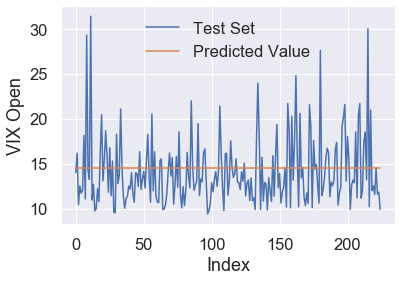

In [226]:
# average model tweet model
## basic model fitting
bm_train, bm_test = train_test_split(model_df_full, train_size=0.7, random_state=42)

train_mean = bm_train['VIX Open'].mean()
# predictors = 'VIX_Open Average'

# Split Data into X,Y
X_train, y_train = (np.ones(bm_train.shape[0]) * train_mean).reshape(-1,1), bm_train['VIX Open']
X_test, y_test = (np.ones(bm_test.shape[0]) * train_mean).reshape(-1,1), bm_test['VIX Open']

model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Check inital accuracy of Tree model
acc_trees_training = model.score(X_train, y_train)
acc_trees_testing  = model.score(X_test, y_test)

# These are changing with each fit, plus we want a more validated choice for depth, so do that
print("Simple Decision Trees: R^2, Training Set \t : {:.2%}".format(acc_trees_training))
print("Simple Decision Trees: R^2, Testing Set \t : {:.2%}".format(acc_trees_testing))

from sklearn.metrics import mean_squared_error

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print("Train MSE", mean_squared_error(y_train, y_pred_train))
print("Test MSE", mean_squared_error(y_test, y_pred_test))
print('Average VIX_Open', )

x = np.arange(0,y_test.shape[0],1)
sns.set(font_scale=1.5)
sns.lineplot(x ,y_test, label = 'Test Set')
sns.lineplot(x ,y_pred_test, label = 'Predicted Value')
plt.xlabel('Index')
plt.show()

### Num Tweets

### Num Tweets (Filtered)

### Granular Tweet

### Granular Tweet (Filtered)

### Granular Tweet + DOW